### (5%) Obtener el fichero usando la librería requests
### (15%) Usando línea de comandos importar los datos de dicho fichero en una base de datos que resida en un fichero SQLite


In [1]:
import requests
import bz2
import subprocess


class DataLoader:

    def __init__(self, url: str, database: str, table: str) -> None:
        self.url = url
        self.database = database
        self.table = table

    @property
    def file_name(self) -> str:
        return self.url.split("/")[-1]

    @property
    def data_path(self) -> str:
        return f"./data/{self.file_name}"[:-4]

    def load_data(self) -> None:
        self.download_data()
        command = f"""sh -c \'file="{self.data_path}"; table="{self.table}"; sqlite3 {self.database}.db <<EOF\n.import "$file" "$table"\nEOF\'"""
        subprocess.call(command, shell=True)

    def download_data(self) -> None:
        response = requests.get(self.url)
        if response.status_code == 200:
            with open(self.data_path, "wb") as file:
                file.write(bz2.decompress(response.content))
        else:
            print("Failed to download the file.")

In [17]:
import os

os.mkdir("./data")

In [3]:
dl = DataLoader(url="https://gist.github.com/juanriaza/9b6f7ab3fc1cbda81100fa5d32512fd8/raw/a61db2d8d81789d5c7040eacee7b225bc2b2aa7f/data.csv.bz2",
                database="idealista_db",
                table="idealista_fact",
                )

dl.load_data()

### (30%) Usando la librería sqlite3 deberás responder a las siguientes preguntas mediante queries SQL:

In [5]:
import sqlite3


class QueryDatabase:

    def __init__(self, db_name: str) -> None:
        self.db_name = db_name

    def __enter__(self):
        self.connection = sqlite3.connect(self.db_name)
        self.cursor = self.connection.cursor()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb) -> None:
        self.connection.close()

    def execute(self, query: str, limit: str | None = None) -> None:
        self.cursor.execute(query)
        data = self.cursor.fetchall()
        columns = [column[0] for column in self.cursor.description]
        self.print_table(data, columns, limit)

    @staticmethod
    def print_table(data: list[tuple], columns: list, limit) -> None:
        max_widths = [max(len(str(value)), len(column))
                      for value, column in zip(data[0], columns)]
        for column, width in zip(columns, max_widths):
            print(f"{column:{width}}", end=' | ')
        print()
        print('-' * (sum(max_widths) + (len(columns) * 3)))
        if limit:
            data = data[:limit]
        for row in data:
            for value, width in zip(row, max_widths):
                print(f"{value:{width}}", end=' | ')
            print()

### Número de inmuebles en alquiler que tiene cada cliente profesional por código postal

In [6]:

query = """ 

    SELECT 
        customer_id AS cliente, 
        zipcode AS codigo_postal , 
        COUNT(*) numero_inmuebles
    FROM idealista_fact t 
    GROUP BY customer_id, zipcode 
    HAVING t.is_professional = 1 AND t.transaction_type  = 'rent'
    ORDER BY customer_id;
            
    """


with QueryDatabase("idealista_db.db") as db:
    db.execute(query, limit=10)

cliente                  | codigo_postal | numero_inmuebles | 
--------------------------------------------------------------
393030313430303030323137 | 08001         |                1 | 
393030313430303030323137 | 08003         |                1 | 
393030313430303030323137 | 08009         |                2 | 
393030313430303030323137 | 08011         |                1 | 
393030313430303030323137 | 08013         |                1 | 
393030313430303030323137 | 08014         |                2 | 
393030313430303030323137 | 08017         |                1 | 
393030313430303030323137 | 08019         |                1 | 
393030313430303030323137 | 08020         |                1 | 
393030313430303030323137 | 08021         |                1 | 


### Obtén los siguientes códigos postales de la ciudad de Barcelona:
1. Código postal del precio por metro cuadrado más barato

In [4]:
query = """

    SELECT 
        zipcode, 
        price,
        area,
        CAST(price as REAL) / CAST(area as REAL) AS precio_m2
    FROM idealista_fact t
    WHERE precio_m2 = (
        SELECT MIN(cast(price as REAL) / CAST(area as REAL))
        FROM idealista_fact t
        WHERE transaction_type = 'sale');
        
    """

with QueryDatabase("idealista_db.db") as db:
    db.execute(query, 5)

zipcode | price | area | precio_m2 | 
-------------------------------------
08240   | 0     | 52   |       0.0 | 
08241   | 0     | 76   |       0.0 | 
08319   | 0     | 224  |       0.0 | 
08291   | 0     | 625  |       0.0 | 
08560   | 0     | 21   |       0.0 | 


2. Código postal del precio por metro cuadrado más caro

In [5]:
query = """

    SELECT 
        zipcode,
        price,
        area,
        CAST(price as REAL) / CAST(area as REAL) AS precio_m2
    FROM idealista_fact t
    WHERE precio_m2 = (
        SELECT MAX(cast(price as REAL) / CAST(area as REAL))
        FROM idealista_fact t
        WHERE transaction_type = 'sale');
        
    """

with QueryDatabase("idealista_db.db") as db:
    db.execute(query, 5)


zipcode | price      | area | precio_m2     | 
----------------------------------------------
08027   | 1000000001 | 80   | 12500000.0125 | 
08261   | 1000000001 | 80   | 12500000.0125 | 
08027   | 1000000001 | 80   | 12500000.0125 | 
08261   | 1000000001 | 80   | 12500000.0125 | 
08027   | 1000000001 | 80   | 12500000.0125 | 


### Cliente con la cartera más envejecida

In [6]:
query = """

  SELECT 
    t.customer_id
  FROM idealista_fact t 
  GROUP BY t.customer_id
  ORDER BY AVG(julianday('now') - julianday(t.date_added)) DESC
  LIMIT 1;
   
  """

with QueryDatabase("idealista_db.db") as db:
    db.execute(query)


customer_id                | 
-----------------------------
39323032373530303739373831 | 


### Ciudad con el terreno urbanizable más caro

In [856]:
query = """

WITH avg_prices AS (
    SELECT 
      city,
      AVG(price) AS precio_medio
    FROM idealista_fact
    WHERE subtypology = 'Terreno Urbanizable'
    GROUP BY city
)

SELECT 
  city, 
  precio_medio
FROM avg_prices
WHERE precio_medio = (
    SELECT 
      MAX(precio_medio)
    FROM avg_prices
);

"""



with QueryDatabase("idealista_db.db") as db:
    db.execute(query)


city               | precio_medio      | 
-----------------------------------------
La Roca del Vallès | 143002128.7142857 | 


# PANDAS

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/data.csv", delimiter="|", dtype={"zipcode": str}, parse_dates=["date_added"]) #mixed types warning

### Número de inmuebles en alquiler que tiene cada cliente profesional por código postal

In [8]:
df_result = (
    
    df
    .query("is_professional == 1")
    .groupby(["customer_id", "zipcode"])
    .size()
    .reset_index(name="numero_inmuebles")
    .sort_values(by=["customer_id", "zipcode", "numero_inmuebles"], ascending=False)
    .reset_index(drop=True)
    
)

df_result.head()

,customer_id,zipcode,numero_inmuebles
0,393433303033313033373236,08396,1
1,393433303033313033373236,08394,11
2,393433303033313033373236,08393,1
3,393433303033313033373236,08392,14
4,393433303033313033373236,08360,3


### Obtén los siguientes códigos postales de la ciudad de Barcelona:
1. Código postal del precio por metro cuadrado más barato

In [9]:
df_result = (

    df
    .assign(price_per_m2 = df["price"] / df["area"])
    .groupby("zipcode")["price_per_m2"]
    .min()
    .replace([np.inf, -np.inf], np.nan)
    .idxmin() # coge el primero 

)

df_result


'08001'

2. Código postal del precio por metro cuadrado más caro

In [505]:
df_result = (

    df
    .assign(price_per_m2 = df["price"] / df["area"])
    .groupby("zipcode")["price_per_m2"]
    .max()
    .replace([np.inf, -np.inf], np.nan)
    .idxmax()
    
)

df_result


'08226'

### Cliente con la cartera más envejecida

In [861]:
df_result = (

    df
    .query("is_professional == 1")
    .assign(date_float = df["date_added"].astype(int))
    .groupby("customer_id")["date_float"]
    .mean()
    .idxmin()

)

df_result

17.7 ms ± 575 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Ciudad con el terreno urbanizable más caro

In [ ]:

df_result = (

    df
    .query("subtypology == 'Terreno Urbanizable'")
    .groupby("city")["price"]
    .mean()
    .idxmax()

)

df_result

'La Roca del Vallès'

 ## Un inversor quiere saber por código postal qué propiedades son interesantes. Añade al dataframe de pandas las siguientes columnas

In [13]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import plotly.graph_objects as go
import pandas as pd

pd.set_option('display.float_format', '{:.2f}'.format)


class Chollos:

    def __init__(self, filaname: str) -> None:
        self.df = pd.read_csv(filaname, delimiter="|", dtype={
                              "zipcode": str}, parse_dates=["date_added"])

    def opportunities(self, how: str) -> None:
        self.method = getattr(self, how)

    def calculate(self, granularity: list, filter_condition: str = None, *args, **kwargs) -> None:

        if not isinstance(granularity, list) or not all(isinstance(col, str) for col in granularity):
            raise ValueError(
                "The 'granularity' must be a list of column names.")
        if filter_condition and not isinstance(filter_condition, str):
            raise ValueError("The 'filter_condition' must be a string.")

        self.df_op = (

            self.df
            .pipe(self.filter_on_conditions, conditions=filter_condition)
            .assign(mean_price=self.df.groupby(granularity)['price'].transform('mean'))
            .pipe(self.method, granularity, *args, **kwargs)
            .pipe(self.replace_boolean_values, columns=['over_value', 'normal', 'under_value'])

        )

    @staticmethod
    def std(df: pd.DataFrame, granularity, std_factor_low: float = 1.0, std_factor_high: float = 1.0) -> pd.DataFrame:

        if std_factor_low < 0.0 or std_factor_high < 0.0:
            raise ValueError(
                "Standard deviation factors must be non-negative.")

        return (
            df
            .assign(std_price=df.groupby(granularity)['price'].transform('std'))
            .assign(std_from_mean=lambda x: (x['price'] - x['mean_price']) / x['std_price'])
            .assign(under_value=lambda x: x['price'] < (x['mean_price'] - std_factor_low * x['std_price']))
            .assign(over_value=lambda x: x['price'] > (x['mean_price'] + std_factor_high * x['std_price']))
            .assign(normal=lambda x: ~(x['under_value'] | x['over_value']))
        )

    @staticmethod
    def percentile(df: pd.DataFrame, granularity: list, percentile_low: float = 25.0, percentile_high: float = 75.0) -> pd.DataFrame:

        if percentile_low < 0 or percentile_high > 100:
            raise ValueError("Percentil must be between 0 and 100")

        return (
            df
            .assign(mean_price=df.groupby(granularity)['price'].transform('mean'))
            .assign(under_value=lambda x: x['price'] < np.percentile(x['mean_price'], percentile_low))
            .assign(over_value=lambda x: x['price'] > np.percentile(x['mean_price'], percentile_high))
            .assign(normal=lambda x: ~(x['under_value'] | x['over_value']))
        )

    @staticmethod
    def mean(df: pd.DataFrame, granularity: list, threshold_factor=1.5) -> pd.DataFrame:

        return (
            df
            .assign(mean_price=df.groupby(granularity)['price'].transform('mean'))
            .assign(over_value=lambda x: (x['price'] > (threshold_factor * x['mean_price'])))
            .assign(normal=lambda x: (x['price'] >= ((1/threshold_factor) * x['mean_price'])) & (x['price'] <= (threshold_factor * x['mean_price'])))
            .assign(under_value=lambda x: x['price'] < ((1/threshold_factor) * x['mean_price']))
        )

    def show(self, field: str, n: int, save: str | None = None):

        df_graph = (
            self.df_op
            .assign(opportunity=self.df_op[["normal", "under_value", "over_value"]].idxmax(axis=1))
            .pipe(lambda df: df[df[field].isin(random.sample(list(set(df[field].values)), n))])
        )

        color_mapping = {'normal': 'grey',
                         'under_value': '#00FF00',
                         'over_value': 'red'}

        sns.set(style="ticks")
        plt.figure(figsize=(8, 12))
        plt.scatter(x=df_graph['price'],
                    y=df_graph[field],
                    c=df_graph['opportunity'].map(color_mapping),
                    s=[50 if s == 'under_value' else 20 for s in df_graph['opportunity']]
                    )

        for i, code in enumerate(df_graph[field].unique()):
            plt.axhline(i, color='grey', linestyle='--')

        ax = plt.gca()
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
        plt.xlabel('Price')
        plt.ylabel(field)
        plt.ylim(-1, len(df_graph[field].unique()) - 0)
        plt.tick_params(axis='both', which='both', bottom=True, left=False)

        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['normal'], markersize=10),
                           plt.Line2D([0], [0], marker='o', color='w',
                                      markerfacecolor=color_mapping['under_value'], markersize=10),
                           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['over_value'], markersize=10)]

        plt.legend(legend_elements, [
            'Normal', 'Under Value', 'Over Value'], loc='upper right')
        plt.title(f"Opportunities by {field}")
        
        if save:
            plt.savefig(f"data/{save}.png")
        plt.show()

    def export(self, path: str, format: str = "csv", compression: str = None):
        if format == "csv":
            self.df_op.to_csv(path, compression=compression)
        elif format == "json":
            self.df_op.to_json(path, compression=compression)


    # UTILS

    @staticmethod
    def replace_boolean_values(df: pd.DataFrame, columns: list) -> pd.DataFrame:
        return df.assign(**{col: df[col].astype(int) for col in columns})

    @staticmethod
    def filter_on_conditions(df: pd.DataFrame, conditions: str) -> pd.DataFrame:
        if conditions:
            conditions_parsed = conditions.split(",")
            query_string = " and ".join(conditions_parsed)
            df = df.query(query_string)
        return df

Mean threshold method

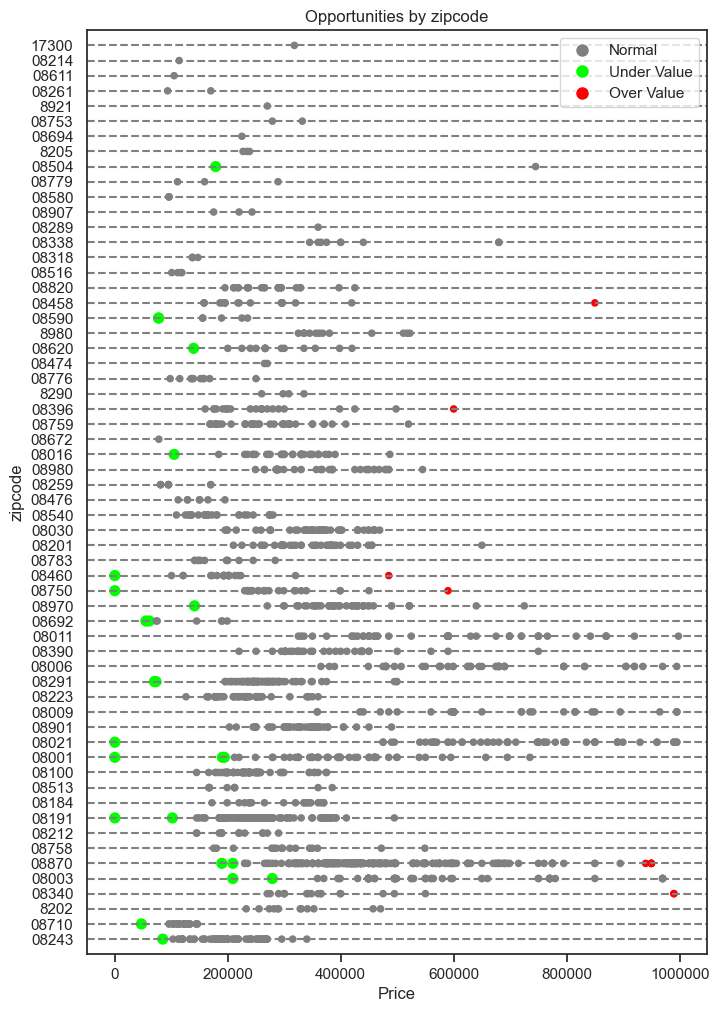

In [14]:
chollo = Chollos("data/data.csv")
chollo.opportunities("mean")
chollo.calculate(
            granularity=["zipcode"], 
            filter_condition="bedrooms == 3, bathrooms == 2, typology == 'Vivienda' and price >= 0 and price <= 1000000 and transaction_type == 'sale'", 
            threshold_factor = 2
            )
chollo.show(field="zipcode", n=60, save = "fig_opportunities_mean")
chollo.export("data/opportunities_mean.csv.gz", compression="gzip")

std  method

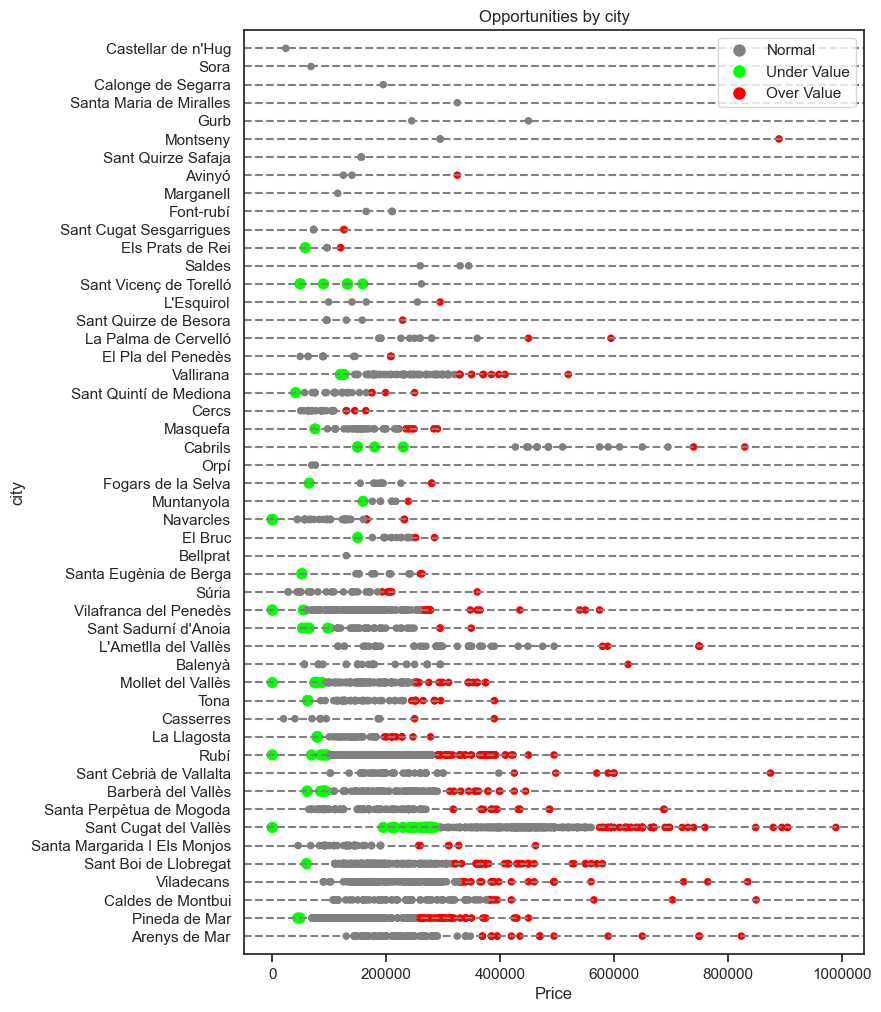

In [16]:
chollo = Chollos("data/data.csv")
chollo.opportunities("std")
chollo.calculate(
            granularity=["city", "typology", "bedrooms",  "transaction_type"], 
            filter_condition="typology == 'Vivienda' and bedrooms == 3 and price >= 0  and price <= 1000000 and transaction_type == 'sale'", 
            std_factor_low = 1.5,
            std_factor_high = 1

            )
chollo.show(field="city", n=50, save = "fig_opportunities_std")
chollo.export("data/opportunities_std.json.gz", format="json", compression="gzip")


Percentil method

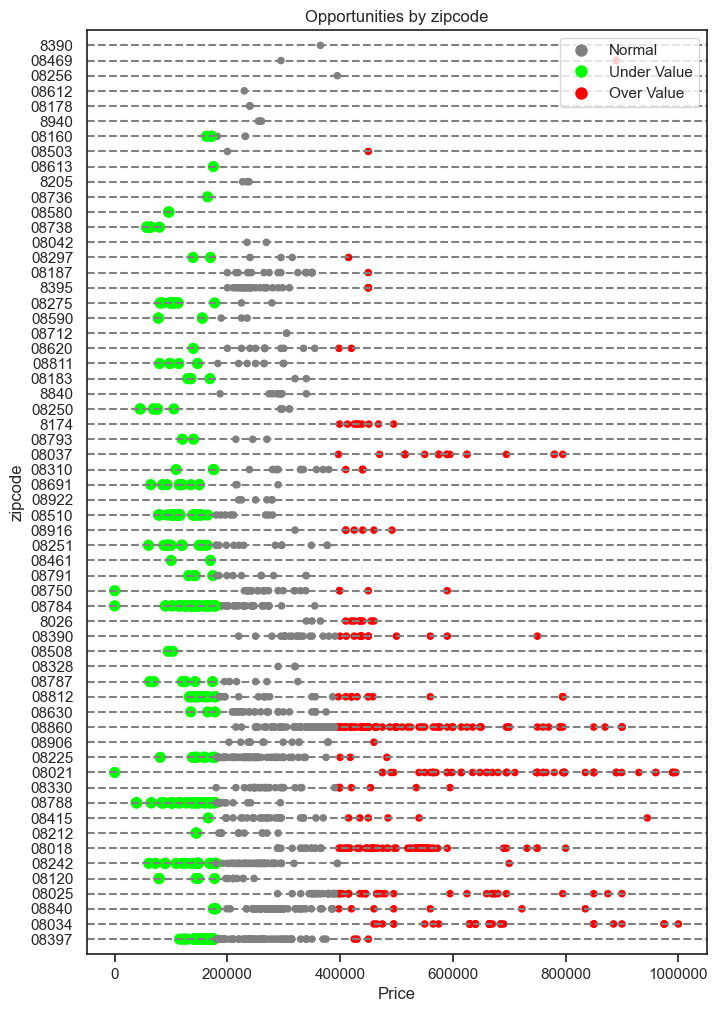

In [1069]:
chollo = Chollos("data/data.csv")
chollo.opportunities("percentile")
chollo.calculate(
            granularity=["zipcode"], 
            filter_condition="bedrooms == 3, bathrooms == 2, typology == 'Vivienda' and price >= 0 and price <= 1000000 and transaction_type == 'sale'",
            percentile_low = 10.0, 
            percentile_high  = 75.0 
            )
chollo.show(field="zipcode", n=60, save = "fig_opportunities_percentile")
chollo.export("data/opportunities_percentile.csv.gz", compression="gzip")

In [511]:
import pandera as pa
from pandera.typing import Series
from datetime import datetime
from IPython.display import display


class IdealistaFact(pa.DataFrameModel):

    customer_id: Series[str]
    city: Series[str] 
    typology: Series[str]
    subtypology: Series[str] = pa.Field(nullable=True)
    transaction_type: Series[str] = pa.Field(isin=["rent", "sale"])
    price: Series[int] = pa.Field(gt=0)
    zipcode: Series[str]
    bedrooms: Series[int]
    bathrooms: Series[int]
    area: Series[int] = pa.Field(gt=0)
    area_land: Series[int] = pa.Field(gt=0)
    is_professional: Series[int] = pa.Field(isin=[0, 1])
    date_added: Series[datetime]


    @pa.check("zipcode", name="zipcode_check")
    def zipcode_check(cls, zipcode: Series[int]) -> Series[bool]:
        return zipcode.str.contains(r"0[1-9][0-9]{3}|[1-4][0-9]{4}|5[0-2][0-9]{3}")

      

try:
    IdealistaFact.validate(df, lazy=True)
except pa.errors.SchemaErrors as err:
    print(err)
    display(err.failure_cases)


Schema IdealistaFact: A total of 4 schema errors were found.

Error Counts
------------
- SchemaErrorReason.SCHEMA_COMPONENT_CHECK: 4

Schema Error Summary
--------------------
                                                                                                                                                                                                                                                                                                          failure_cases  n_failure_cases
schema_context column    check                                                                                                                                                                                                                                                                                                          
Column         area      greater_than(0)                                                                                                                             

,schema_context,column,check,check_number,failure_case,index
0,Column,price,greater_than(0),0,0,248
76209,Column,area_land,greater_than(0),0,0,79288
76515,Column,area_land,greater_than(0),0,0,79618
76514,Column,area_land,greater_than(0),0,0,79617
76513,Column,area_land,greater_than(0),0,0,79616
...,...,...,...,...,...,...
38250,Column,area_land,greater_than(0),0,0,36777
38249,Column,area_land,greater_than(0),0,0,36776
38248,Column,area_land,greater_than(0),0,0,36775
38247,Column,area_land,greater_than(0),0,0,36773
